## Preliminares y funciones

In [1]:
import numpy as np
import seaborn, os
from matplotlib import pyplot as plt

In [2]:
%run ../medidas_biodiversidad.py

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
seaborn.set_palette("deep", color_codes=True)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.figsize'] = (6.5, 6)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [5]:
def leer_datos(het, exp = 'S1'):
    directorio = "../datos/exp{}".format(exp)
    files = os.listdir(directorio)
    files.sort()
    files = list(filter(lambda x: x[7] == het, files))
    
    datos = [np.load(directorio + '/' + file) for file in files]
    comunidad = [file[10:13] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    median = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[:, i])
        std[i] = np.std(riquezas[:, i])
        median[i] = np.median(riquezas[:, i])
    return promedios, std, median

In [7]:
def ajustar_polinomio(riquezas, grado, sd):
    x = np.array(range(10)) / 10

    res = np.polyfit(x, riquezas, grado, w=1/sd)
    p = np.poly1d(res)
    r2 = 1 - ((np.sum((p(x) - riquezas)**2)) /
             (np.sum((riquezas - np.mean(riquezas))**2)))
    
    r2_adj = r2 - (1 - r2) * (grado/(10-grado-1))
    
    return res, p, r2_adj

In [8]:
def bootstrap(data, n=100):
    boo = np.zeros((n, len(data)))
    boo_means = np.zeros(n)
    
    mean = np.mean(data)
    for i in range(n):
        idx = np.random.randint(0, len(data), size=len(data))
        boo[i] = data[idx]
        boo_means[i] = np.mean(boo[i])
    
    sort = np.sort(boo_means - mean)
    
    #intervalo = [mean - sort[-5], mean-sort[4]]
    intervalo = sort[[-5, 4]]

    return intervalo

## Leer datos, calcular riqueza

In [125]:
datos = np.zeros((3, 100, 10, 1, 10, 10, 10)) # het, comunidad, intensificación, tiempo, x, y, especies
for i, het in enumerate([0, 1, 4]):
    datos[i] = leer_datos(str(het), 'S8')[0]

In [132]:
riqueza_total = np.zeros((3, 100, 10)) # het, comunidad, intensificación

for i, het in enumerate([0, 1, 4]):
    for comunidad in range(len(datos[i])):
        for intensificacion in range(len(datos[i, comunidad])):
            riqueza_total[i, comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[i, comunidad, intensificacion, ...],
                                                    t=-1, biomasa_min = 35)[1]

¿Cuántas comunidades no tuvieron cambios en el nivel de heterogeneidad intermedio (het=2)? Este es el criterio para distinguir si la dinámica de migración y población están acopladas. El resto del análisis se hace sólo con estas comunidades, que son 80.

# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
count = 0
con_cambios = []
for het in [1]:
    for c in range(100):
        if riqueza_total[het][c, 0] != riqueza_total[het][c, 9]:
            count += 1
            con_cambios.append(c)
100-count

In [133]:
#con_cambios = list(range(100))

In [134]:
#np.save('./con_cambios', con_cambios)
con_cambios = np.load('con_cambios.npy')

In [135]:
riqueza_total_mean = np.zeros((3, 10)) # het, intensificación
riqueza_total_sd = np.zeros((3, 10)) # het, intensificación

for het in range(3):
    riqueza_total_mean[het] = calcular_promedio(riqueza_total[het, con_cambios, :])[0]
    riqueza_total_sd[het] = calcular_promedio(riqueza_total[het, con_cambios, :])[1]

## Intervalos confianza

In [136]:
intervalos = np.zeros((3, 10, 2)) #het, int, high/low
for h in range(3):
    for i in range(10):
        intervalos[h, i] = bootstrap(riqueza_total[h, con_cambios, i])

## Figure 3

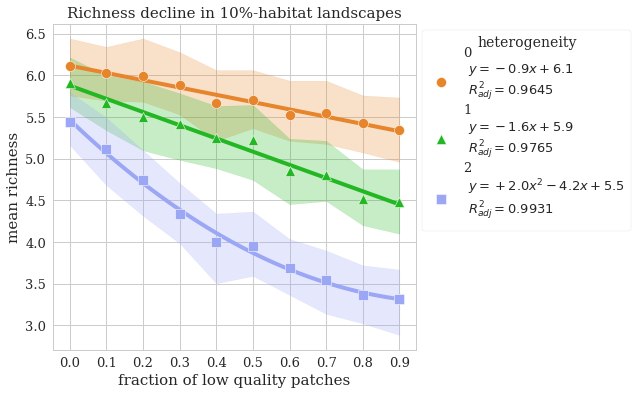

In [137]:
fig3()

## Función fig

In [19]:
def fig3():
    res = [None] * 5
    p = [None] * 5
    r2_adj = [None] * 5
    label = [None] * 5
    
    for het in range(3):
        res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 2, riqueza_total_sd[het])
        label[het] = '$y = {:+.1f} x^2 {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
        
        if ajustar_polinomio(riqueza_total_mean[het], 1, riqueza_total_sd[het])[2] > r2_adj[het]:
            res[het], p[het], r2_adj[het] = ajustar_polinomio(riqueza_total_mean[het], 1, riqueza_total_sd[het])
            
            label[het] = '$y = {:+.1f} x {:+.1f}$ \n $R^2_{{adj}}={:.4f}$ '.format(
                 float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
    
    x = np.linspace(0, .9, 100)
    xdata = np.array(range(10)) / 10
    xlabels = np.array(range(10)) / 10

    puntos = ["o", "^", "s", "s", "s"]
    colores = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']
    
    fig = plt.figure()

    for het in range(3):
        plt.plot(x, p[het](x), lw = 4, color= colores[het]) #fit
        plt.plot(xdata, riqueza_total_mean[het], marker=puntos[het], color= colores[het], 
                 ls='None', ms=10, mec='white', mew=.5,
                 label='{} \n {}'.format(het, label[het])) #data points
        #plt.errorbar(xdata, riqueza_total_mean[het], color=colores[het], yerr=np.abs(np.transpose(intervalos[het])), 
        #             fmt=puntos[het], capsize=5, elinewidth=2, capthick=2)
        plt.fill_between(xdata,riqueza_total_mean[het]+intervalos[het, :, 0], 
                         riqueza_total_mean[het]+intervalos[het, :, 1], color=colores[het], alpha=.25)
    #plt.ylim(2.9, 6.7)
    #plt.xlim(-0.01, .91)
    plt.xticks(xdata, xlabels)
    plt.xlabel("fraction of low quality patches")
    plt.ylabel('mean richness')
    plt.title('Richness decline in 10%-habitat landscapes')
    plt.legend(loc='upper left', title="heterogeneity", bbox_to_anchor=(1, 1), frameon=1)
    #plt.tight_layout()
    #plt.savefig('fig3.png', dpi=300, bbox_inches='tight')